# I Import des données ####################

In [3]:
import pandas as pd

df = pd.read_csv('SBAnational.csv', low_memory=False)
# df = df.sample(n = 10000)
# print(df.head())
# print(df.info())

In [ ]:
y_train[df.index]

In [2]:
df.index

Int64Index([307221, 683847, 891314, 182617, 132258,  46417, 686399, 173221,
             62185, 576154,
            ...
            748169, 747625, 264420, 481066, 847103, 647967, 536615, 202760,
            847116, 753993],
           dtype='int64', length=10000)

# II Nettoyage des données

In [4]:
def cleaning(df):


    # Columns Selection
    df = df.drop(columns=['Name', 'LoanNr_ChkDgt', 'Bank', 
                     'BankState', 'DisbursementDate', 'ApprovalDate', 
                    'ApprovalFY', 'FranchiseCode', 'Zip', 'City', 'ChgOffDate', 'SBA_Appv', 'BalanceGross', 'DisbursementGross', 'ChgOffPrinGr'])
    # Deal with NA
    df = df.dropna(subset=['MIS_Status']) 

    # Data formating for training data (outside pipe)
    df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')    
    df['RevLineCr'] = df['RevLineCr'].mask(df.RevLineCr.isin(['0','T','1','R','`','2','C','3',',','7','A','5','.','4','-','Q']))   
    df['LowDoc'] = df['LowDoc'].mask(df.LowDoc.isin(['0','C','S','A','R','1'])) 
    df['NewExist'] = df['NewExist'].replace({2:False, 1:True})   
    df['NAICS'] = df['NAICS'].astype('str').apply(lambda x : x[:2])    
    return df

df = cleaning(df)

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_71081/2867805252.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')


# III Train / Test / Split

In [5]:
from sklearn.model_selection import train_test_split
y = df['MIS_Status'].replace({'P I F':0, 'CHGOFF':1}) 
X = df.drop(['MIS_Status'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False,test_size=0.2, random_state=42)

# print(df.head())
# print(df.info())

In [6]:
X_train_sample = X_train.sample(n = 10000)
y_train_sample = y_train[X_train_sample.index]

# IV Construction du Pipeline

In [43]:
# ############### IV.a Numeric features ##############
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)

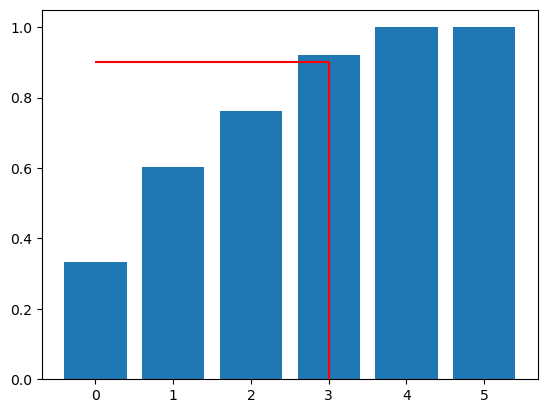

In [44]:
####### Analyse best PCA

from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_transformer = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ('pca', PCA(n_components=5)) # après standardisation
        ])


# ############### IV.c Categorial features ##############
categorial_features = ['RevLineCr', 'LowDoc', 'NewExist', 'NAICS', 'State']

from sklearn.preprocessing import OneHotEncoder
categorical_transformer = OneHotEncoder(sparse=True)



# ############### IV.d Combinaison ##############
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ],
    remainder="passthrough" 
)


############### IV.d Estimator ##############
from xgboost import XGBClassifier
# xg = XGBClassifier(**(model_fit["clf"].get_params()))
xg = XGBClassifier()

# ############### IV.d Final_pipe ##############

from sklearn.pipeline import Pipeline
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg)
])

In [65]:
# ############### V.b Cross Validation ##############

from sklearn.model_selection import KFold

# define evaluation
cv = KFold(n_splits=5, random_state=1,shuffle = True)

# ############### V.c Hyparameters space setting ##############

# import numpy as np

positives = sum(y) / len(y)
negatives = 1 - positives
scale_ratio = negatives / positives

space = {'clf__max_depth' : [7,12,15],
              'clf__learning_rate' : [0.5],
              'clf__gamma' : [1],
              'clf__reg_lambda' : [15],
              'clf__scale_pos_weight' : [scale_ratio]
              }

# ############### V.d RandomSearch and GridSearc ##############


from sklearn.model_selection import GridSearchCV
grid_pipe = GridSearchCV(
    pipe,
    space,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1,
    cv=cv
)


In [66]:
import mlflow
try:
    experiment_id = mlflow.get_experiment_by_name("loan_analysis").experiment_id
except AttributeError:
    experiment_id = mlflow.create_experiment("loan_analysis")


In [68]:
import mlflow
from mlflow.models.signature import infer_signature
run_name = "grid_no_tuning_to_deploy"


with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    model_fit = grid_pipe.fit(X_train, y_train)
    
    for param,value in model_fit.best_estimator_[-1].get_params().items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("PCA", True) 

    # Log model
    
    signature = infer_signature(X_train, model_fit.best_estimator_.predict(X_train))

    
    mlflow.sklearn.log_model(model_fit.best_estimator_, "xgboost_with_PCA", signature=signature)

    model_uri = mlflow.get_artifact_uri("xgboost_with_PCA")
    
    
    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/l

[11:36:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=7, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  10.5s
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=7, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  10.6s
[11:36:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=7, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  12.0s


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/pipeline.py", line 46, in check
   

[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=7, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  11.5s
[11:36:21] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=12, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  16.0s


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=12, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  16.3s
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=12, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  14.7s


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/pipeline.py", line 46, in check
   

[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=12, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  14.0s
[11:36:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=15, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  16.7s


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=15, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  18.0s
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=15, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  13.4s
[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=15, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=  10.5s


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 127, in __get__
    if not self.check(obj):
  File "/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/sklearn/pipeline.py", line 46, in check
   

[CV] END clf__gamma=1, clf__learning_rate=0.5, clf__max_depth=15, clf__reg_lambda=15, clf__scale_pos_weight=4.546414674819344; total time=   7.9s
[11:36:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings

<Figure size 1050x700 with 0 Axes>

# Prediction

## Load model to predict

In [69]:
import mlflow
logged_model = 'runs:/e4e716729afd4b6785c593edee20a2cc/xgboost_with_PCA'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(X_test.iloc[0:30])

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

## Serve model to predict

Serving:

mlflow models serve --model-uri runs:/e4e716729afd4b6785c593edee20a2cc/xgboost_with_PCA --port 5001

mlflow models build-docker --model-uri runs:/e4e716729afd4b6785c593edee20a2cc/xgboost_with_PCA --name "xgboost_with_PCA"


ça n'a pas marché chez moi.

modifier Dockerfile

FROM ubuntu:20.04


RUN apt-get dist-upgrade
RUN apt-get update 
RUN DEBIAN_FRONTEND=noninteractive TZ=Etc/UTC apt-get install -y --no-install-recommends          wget          curl          nginx          ca-certificates          bzip2          build-essential          cmake          openjdk-8-jdk          git-core          maven     && rm -rf /var/lib/apt/lists/*
...

In [16]:
import requests
import json 

data = {
    "dataframe_split": X_test.iloc[0:2].to_dict(orient='split')}

json_object = json.dumps(data) 

url = 'http://127.0.0.1:5001/invocations'
headers = {"Content-Type": "application/json"}

my_request = requests.post(url, data=json_object,headers = headers )
my_request.text

'{"predictions": [0, 0]}'

In [17]:
print(json_object)

{"dataframe_split": {"index": [719461, 719462], "columns": ["State", "NAICS", "Term", "NoEmp", "NewExist", "CreateJob", "RetainedJob", "UrbanRural", "RevLineCr", "LowDoc", "GrAppv"], "data": [["TX", "0", 60, 4, true, 0, 0, 0, "N", "Y", 25000], ["CA", "53", 240, 11, true, 4, 0, 1, NaN, "N", 425000]]}}


In [ ]:
# curl http://127.0.0.1:5001/invocations -H 'Content-Type: application/json' -d '{"dataframe_split": {"columns": ["State","NAICS","Term","NoEmp","NewExist","CreateJob","RetainedJob","UrbanRural","RevLineCr","LowDoc","GrAppv"],"data": [["NV","42",84,10,true,0,0,1,"Y","N",250000],["WA","0",180,4,1,0,0,0,"N","Y",100000],["IL","81",90,2,0,0,2,1,"N","N",160000]]}}'

# Learning curve

In [ ]:
import warnings
warnings.filterwarnings('ignore')
############### V.f LearningCurve ##############

best_model_params = model_fit["clf"].get_params()
xg_best = XGBClassifier(**best_model_params)
best_pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg_best)
])

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

N, train_score, val_score = learning_curve(best_pipe, X_train, y_train,cv=cv)

[ 638 2074 3511 4947 6384]


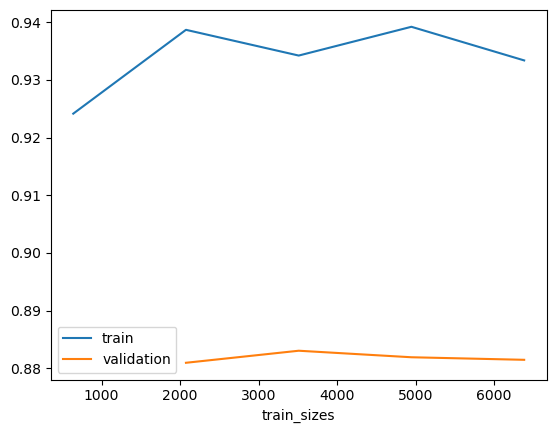

In [78]:
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()